In [234]:
%matplotlib inline
import chainer
import chainer.functions as F
import chainer.links as L
import chainer.cuda
from chainer import optimizers
from chainer import serializers
import numpy as np
import matplotlib.pyplot as plt

In [235]:
n_epoch = 50
batchsize = 30
bprop_len = 1000
n_unit = 100
grad_clip = 5

In [236]:
xp = np

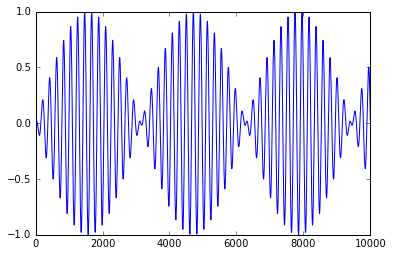

In [241]:
t = np.arange(0,10,0.001, dtype=np.float32)
train_data = np.sin(t) * np.cos(30 * t)
#train_data = np.sin(t)
plt.plot(train_data)

In [242]:
class RNN(chainer.Chain):
    def __init__(self, n_unit):
        super(RNN, self).__init__(
            l1 = L.Linear(1, n_unit),
            l2 = L.LSTM(n_unit, n_unit),
            l3 = L.Linear(n_unit, 1)
        )
    
    def __call__(self,x,t):
        return F.mean_squared_error(self.predict(x),t)
        
    def reset_state(self):
        self.l2.reset_state()
    
    def predict(self,x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        y = self.l3(h2)
        return y

In [243]:
model = RNN(n_unit)
optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))

length = train_data.shape[0]
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data[(jump * j + i) % length]] for j in batch_idxs]))
    t = chainer.Variable(xp.asarray([[train_data[(jump * j + i + 1) % length]] for j in batch_idxs]))
    loss_i = model(x,t)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        optimizer.lr /= 1.2
        print('epoch {}, accum_loss {}'.format(epoch, loss_data / length))
        loss_data = 0
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 1, accum_loss 0.3958755676597357
epoch 2, accum_loss 1.1617116271972656
epoch 3, accum_loss 1.9272998504638672
epoch 4, accum_loss 0.22028624819926917
epoch 5, accum_loss 0.6382507652282715
epoch 6, accum_loss 1.0626548301696777
epoch 7, accum_loss 0.1549214046880603
epoch 8, accum_loss 0.44439045095443724
epoch 9, accum_loss 0.741803927230835
epoch 10, accum_loss 0.12905708449538797
epoch 11, accum_loss 0.36445862965583803
epoch 12, accum_loss 0.6078610210418701
epoch 13, accum_loss 0.11647789408117533
epoch 14, accum_loss 0.32571711049079893
epoch 15, accum_loss 0.5433882284164429
epoch 16, accum_loss 0.10987832357790321
epoch 17, accum_loss 0.30525872855186464
epoch 18, accum_loss 0.5107620307922364
epoch 19, accum_loss 0.10707511432096362
epoch 20, accum_loss 0.2948204142570496
epoch 21, accum_loss 0.49367374029159544
epoch 22, accum_loss 0.1061860053503886
epoch 23, accum_loss 0.28867635698318483
epoch 24, accum_loss 0.48342173595428467
epoch 25, accum_loss 0.106377206973545

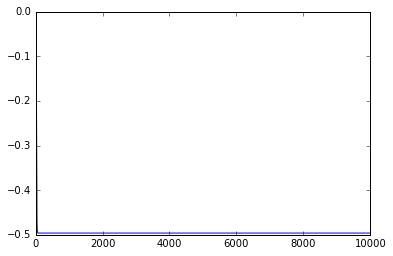

In [244]:
t = chainer.Variable(xp.array([[0]],dtype=np.float32))
output = []
model.reset_state()
for i in range(length):
    t = model.predict(t)
    output.append(t.data[0])
plt.plot(output)